In [ ]:
#Nhập các thư viện cần thiết để họ trợ phân tích
import pandas as pd 
import os
import plotly.graph_objs as go
import plotly.tools as tls
import chart_studio.plotly as py
import plotly.offline as py
import squarify
import seaborn as sns
import geojson
import IPython.display
from plotly.graph_objs import Data
import matplotlib.pyplot as plt
from IPython.display import Image


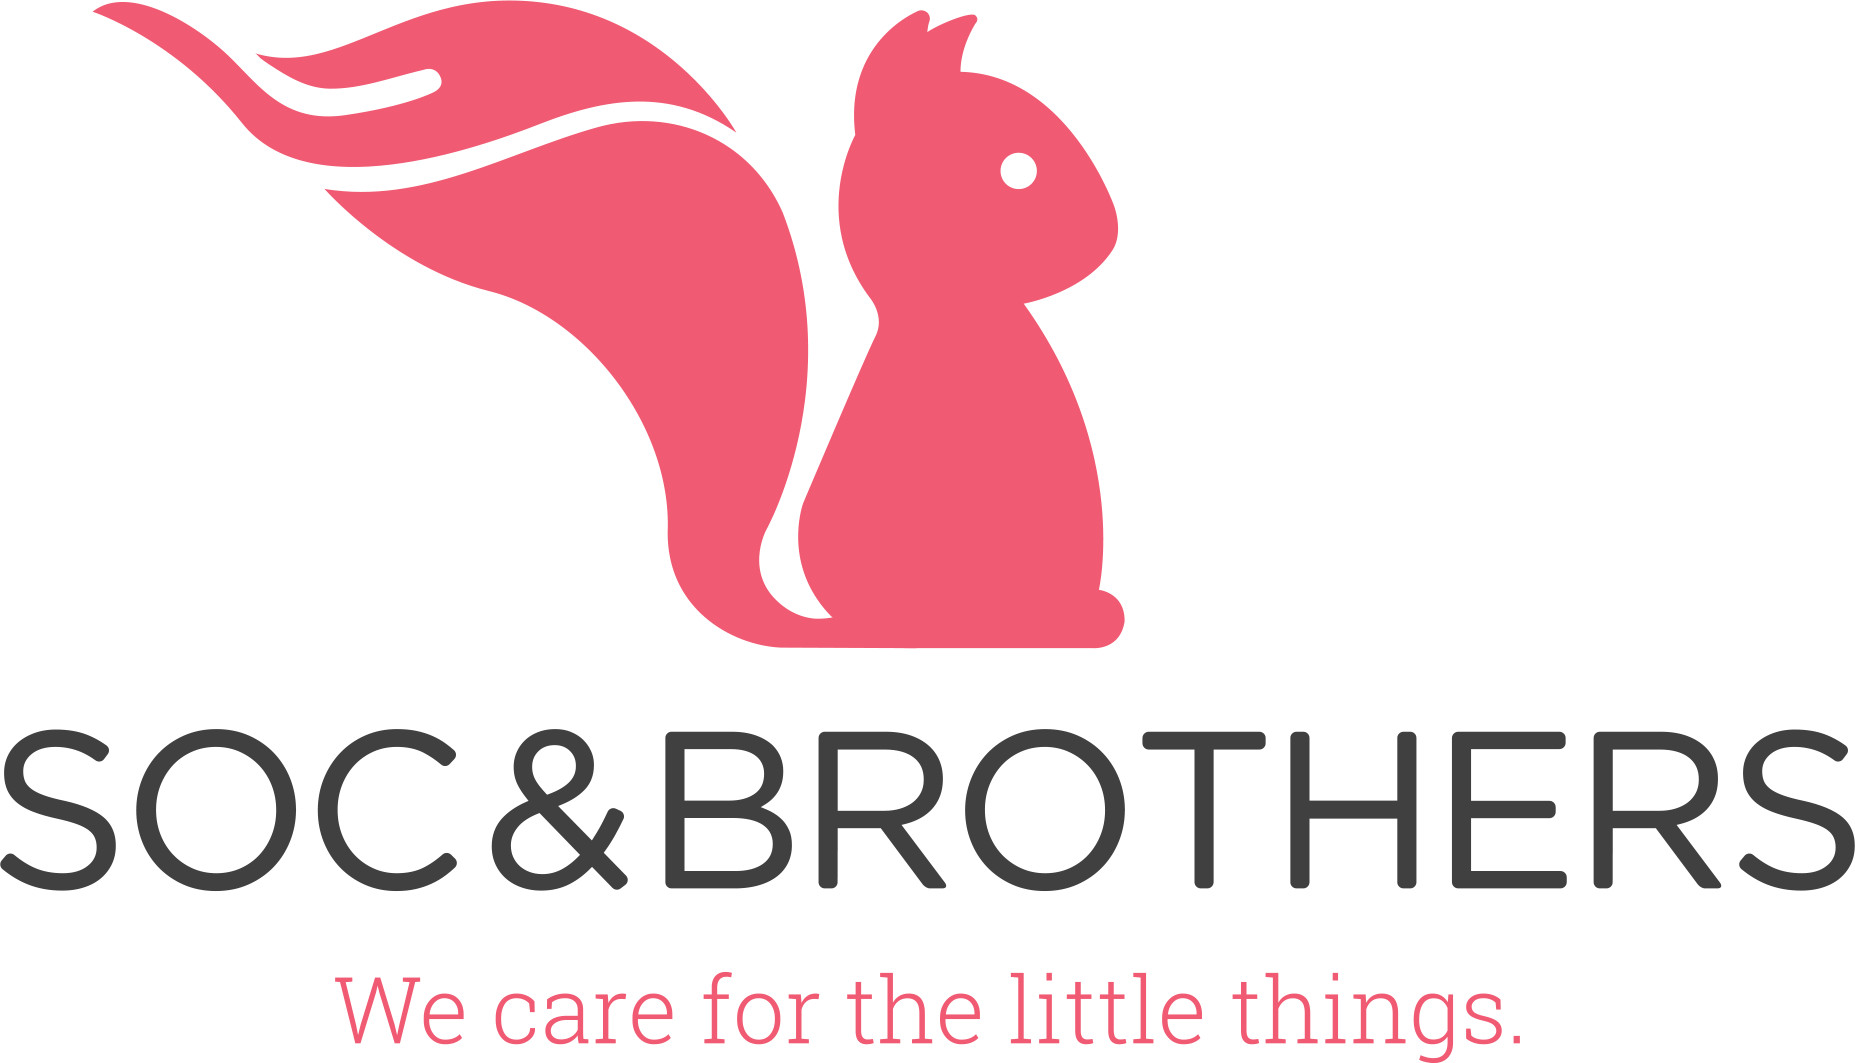

In [ ]:
Image(filename='icon-snb.jpg')

# Giới thiệu

Dự án tập trung nghiên cứu phân tích dữ liệu lịch sử bán lẻ của các chi nhánh bán lẻ chính của SNB. Nhằm phân tích xem xu hướng mua hàng khách hàng, doanh thu bán hàng của các cửa hàng bán lẻ và quan trọng nhất là xác định được chân dung khách hàng (buyer persona)

Trong dự án này, chúng tôi đã ứng dụng mô hình RFM để hỗ trợ cho việc phân tích và trả lời cho câu hỏi chính (xác định buyer persona). Ngoài ra còn kết hợp việc phân tích thống kê và chuỗi thời gian để quan sát và lọc ra các điểm dữ liệu ẩn danh (anonymous).

Báo cáo bao gồm 8 phần

*   **Thông tin dữ liệu**

Giới thiệu sơ nét dữ liệu:"kích cỡ dữ liệu, bao nhiêu quan sát, bao nhiêu giá trị khuyết,..."

*   **Xử lý phân tích doanh thu theo thời gian**

Nhóm thông tin doanh thu theo giời gian và quan sát tổng doanh thu theo thời gian từ tháng 1/2021 đến ngày 13/7/2022. Đánh giá các biến động doanh thu, xem nó có tính chu kỳ hay không?

*   **Phân tích tần suất bán hàng**

Nhóm thông tin tần suất mua hàng của khách hàng đánh giá xem xu hướng mua hàng của khách hàng theo từng mức hạng thẻ. Phân tích và lọc ra các điểm dữ liệu mua hàng bất thường (outliers/anonymous).

*   **Phân tích doanh thu đơn hàng**

Nhóm thông tin doanh thu của các khách hàng đánh giá xem xu hướng doanh thu mang về từ những khách hàng tương ứng với từng mức hạng thẻ

*   **Lọc các điểm dữ liệu bí ẩn khỏi bộ dữ liệu**

Nhằm chống hạn chế đi những ước tính lệch khi dùng mô hình RFM, cần lọc ra các quan sát được cho là bất thường.

*   **Mô hình hóa dữ liệu bằng mô hình RFM**

Xây dựng các chỉ số cần thiết của mô hình R-F-M từ bộ dữ liệu để phục vụ cho việc đánh giá phân hạng và phân khúc khách hàng

*   **Xếp hạng khách hàng chung bằng mô hình RFM**

Lọc ra các khách lẻ có định danh (Tần suất bằng một), sau đó tiến hàng đánh giá chung tình hình xu hướng của từng phân khúc khách theo ba tiêu chí chính của RFM

*   **Phân tích khách hàng thông qua RFM theo từng cửa hàng**

Gộp lại nhóm khách lẻ vào dữ liệu và tiến hành đánh giá xem phân bố từng phân khúc khách hàng trên từng chi nhánh







# Thông tin dữ liệu

In [ ]:
#Nhập dữ liệu từ 4 file tác biết lưu lại lịch sử giao dịch từ HT-soft trong khoảng thời gian từ tháng 1/2021 đến 13/7/2022
jan_ap21 = pd.read_excel('Jan_Apr21.xlsx')
may_au21 = pd.read_excel('May_Aug21.xlsx')
sep_dec21 = pd.read_excel('Sep_Dec21.xlsx')
jan_jul_22 = pd.read_excel('Jan_Jul13_22.xlsx')

#gom các file dữ liệu ấy về thành một dataframe, và thao tác chính trên đây
df_source = pd.concat([jan_ap21, may_au21, sep_dec21, jan_jul_22]).reset_index()
df_source.head()
#Xóa các biến không cần thiết để chống tốn tài nguyên
del jan_ap21, jan_jul_22, may_au21, sep_dec21

In [ ]:
#Bỏ các cột không cần thiết để tiện quan sát dữ liệu hơn
df = df_source.drop(columns=['Nhóm hàng','Nhân viên', 'Ghi chú', 'Tên NCC', 'Ngày cập nhật', 'Số SO', 'Line type','index'])

In [ ]:
#Các thuộc tính của dữ liệu
df.columns

Index(['Mã hàng', 'Tên hàng', 'Ngày', 'Số phiếu', 'Lý do', 'Số lượng',
       'Đơn giá', 'Đơn giá sau thuế', 'Thuế suất', 'ĐVT', 'Chiết khấu($)',
       'Thành tiền', 'Thành tiền trước thuế cộng chiết khẩu', 'Mã NV', 'Kho',
       'Khách hàng', 'Mã KH', 'Trả lại', 'Thuế', 'Chi nhánh', 'Hình thức TT',
       'Mã NCC', 'Khu vực', 'Hạng thẻ', 'CK KHTT(%)', 'CK(%)', 'Nhóm C1',
       'Nhóm C2', 'Nhóm C3', 'Xuất xứ', 'Doanh thu', 'Số phiếu mới', 'Brand',
       'TT Bán >0 va HBTL <> 0', 'Mã KM', 'Nguồn đơn hàng', 'TT trước thuế',
       'User', 'NCC'],
      dtype='object')

In [ ]:
#Dữ liệu có 889071 quan sát, có 39 thuộc tính trong đó có các cột bị thiếu thông tin như ('Đơn giá','Đơn giá sau thuế','ĐVT',...)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889071 entries, 0 to 889070
Data columns (total 39 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   Mã hàng                                889071 non-null  object        
 1   Tên hàng                               889071 non-null  object        
 2   Ngày                                   889071 non-null  datetime64[ns]
 3   Số phiếu                               889071 non-null  object        
 4   Lý do                                  889071 non-null  object        
 5   Số lượng                               889071 non-null  int64         
 6   Đơn giá                                885165 non-null  float64       
 7   Đơn giá sau thuế                       883302 non-null  float64       
 8   Thuế suất                              887069 non-null  float64       
 9   ĐVT                                    879787 no

In [ ]:
#SNB có tổng cộng 6 chi nhánh chính 
df['Chi nhánh'].value_counts()

PCT#SNB-PCT            376067
THN#THNC               223563
LGI#SNB - Liễu Giai    182378
JIS#SNB-JIS             82358
HCM-SNB-ĐBP             24062
HN1-SNB-Sales             643
Name: Chi nhánh, dtype: int64

# Xử lý phân tích doanh thu theo thời gian

In [ ]:
#Lọc chỉ lấy dữ liệu và loại ra các thông tin quan sát về các tặng phẩm cũng như khuyến mãi 
df = df[df['Lý do']=='XBA'] #Lọc chỉ lấy dữ liệu thông tin về phiếu bán lẻ
df=  df[df['Đơn giá']>1] #Lọc thông tin dữ liệu có đơn giá lớn hơn 1 nhằm loại đi các tặng phẩm
df= df[df['Số lượng']>0] #Lọc thông tin dữ liễu có số lượng lớn hơn 1 nhằm loại đi các voucher khuyến mãi
#Phân phối đơn giá
df['Đơn giá'].describe()

count    6.968930e+05
mean     1.680154e+05
std      3.871433e+05
min      2.000000e+02
25%      4.727273e+04
50%      8.636364e+04
75%      1.809091e+05
max      1.908182e+07
Name: Đơn giá, dtype: float64

In [ ]:
# Vì cột dữ liệu "Ngày" có chứa thông tin thời gian điều này sẽ khiến việc tổng hợp doanh thu theo ngày khó khăn nên ta cần-
#chuẩn hóa cột dữ liệu ngày về dạng ngày (xóa đi thông tin thời gian)
df['Ngày'] = pd.to_datetime(df['Ngày']).dt.date
df['Ngày']

4         2021-01-11
5         2021-02-07
7         2021-01-24
8         2021-04-30
10        2021-03-31
             ...    
889065    2022-06-29
889066    2022-06-10
889067    2022-06-11
889069    2022-06-16
889070    2022-04-11
Name: Ngày, Length: 696893, dtype: object

In [ ]:
client_transaction = df.copy()
client_transaction.drop(columns='Lý do', inplace=True)

In [ ]:
#nhóm dữ liệu theo mã khách-số phiếu-chi nhánh
client_transaction.sort_values(['Mã KH', 'Số phiếu','Chi nhánh'], inplace=True)
client_transaction = client_transaction.set_index(['Mã KH', 'Số phiếu','Chi nhánh'])

In [ ]:
client_transaction.head()

Mã hàng  \
Mã KH Số phiếu    Chi nhánh                            
#     HCM08815528 HCM-SNB-ĐBP          4513574017290   
                  HCM-SNB-ĐBP          4513574027077   
                  HCM-SNB-ĐBP          8059147053228   
      LGIAA050602 LGI#SNB - Liễu Giai  8934681969566   
                  LGI#SNB - Liễu Giai  4966680247103   

                                                                             Tên hàng  \
Mã KH Số phiếu    Chi nhánh                                                             
#     HCM08815528 HCM-SNB-ĐBP                290 VDVS - Sữa tắm mát lạnh Pharma 600ml   
                  HCM-SNB-ĐBP          Sữa tắm sáng da reihaku hatomugi 800ml GDJ-077   
                  HCM-SNB-ĐBP            CHICCO Sữa tắm gội chiết xuất yến mạch 500ml   
      LGIAA050602 LGI#SNB - Liễu Giai           Xịt diệt khuẩn BIORE Guard chai 150ml   
                  LGI#SNB - Liễu Giai     Nước súc miệng Propolinse vị trà xanh 600ml   

                                             Ngày  Số lượng      Đơn giá  \
Mã KH Số phiếu    Chi nhánh                                                
#     HCM08815528 HCM-SNB-ĐBP          2022-04-20         1  209091.0000   
                  HCM-SNB-ĐBP          2022-04-20         1  180909.0909   
                  HCM-SNB-ĐBP          2022-04-20         2  422727.2727   
      LGIAA050602 LGI#SNB - Liễu Giai  2022-02-26         1   53703.7037   
                  LGI#SNB - Liễu Giai  2022-02-26         1  245454.5455   

                                       Đơn giá sau thuế  Thuế suất   ĐVT  \
Mã KH Số phiếu    Chi nhánh                                                
#     HCM08815528 HCM-SNB-ĐBP             230000.100000       10.0   Cái   
                  HCM-SNB-ĐBP             198999.999990       10.0  chai   
                  HCM-SNB-ĐBP             464999.999970       10.0  Bình   
      LGIAA050602 LGI#SNB - Liễu Giai      57999.999996        8.0  chai   
                  LGI#SNB - Liễu Giai     270000.000050       10.0  chai   

                                       Chiết khấu($)   Thành tiền  ...  \
Mã KH Số phiếu    Chi nhánh                                        ...   
#     HCM08815528 HCM-SNB-ĐBP             10454.5500  218500.0950  ...   
                  HCM-SNB-ĐBP              9045.4545  189050.0000  ...   
                  HCM-SNB-ĐBP             42272.7273  883499.9999  ...   
      LGIAA050602 LGI#SNB - Liễu Giai         0.0000   58000.0000  ...   
                  LGI#SNB - Liễu Giai         0.0000  270000.0001  ...   

                                        Xuất xứ    Doanh thu  Số phiếu mới  \
Mã KH Số phiếu    Chi nhánh                                                  
#     HCM08815528 HCM-SNB-ĐBP               NaN  209091.0000  HCM08815528C   
                  HCM-SNB-ĐBP               NaN  180909.0909  HCM08815528C   
                  HCM-SNB-ĐBP            Chicco  845454.5454  HCM08815528C   
      LGIAA050602 LGI#SNB - Liễu Giai  Việt Nam   53703.7037   LGIAA050602   
                  LGI#SNB - Liễu Giai       NaN  245454.5455  LGIAA050602C   

                                            Brand  TT Bán >0 va HBTL <> 0  \
Mã KH Số phiếu    Chi nhánh                                                 
#     HCM08815528 HCM-SNB-ĐBP                 NaN             198636.4500   
                  HCM-SNB-ĐBP                 NaN             171863.6364   
                  HCM-SNB-ĐBP              Chicco             803181.8181   
      LGIAA050602 LGI#SNB - Liễu Giai         NaN              53703.7037   
                  LGI#SNB - Liễu Giai  Propolinse             245454.5455   

                                       Mã KM Nguồn đơn hàng TT trước thuế  \
Mã KH Số phiếu    Chi nhánh                                                 
#     HCM08815528 HCM-SNB-ĐBP            NaN            NaN   198636.4500   
                  HCM-SNB-ĐBP            NaN            NaN   171863.6364   
                  HCM-SNB-ĐBP            NaN    

In [ ]:
#Tạo dữ liệu chứa thông tin tổng doanh thu của toàn bộ chi nhánh bán lẻ
daily_transaction = client_transaction[['Ngày','Doanh thu','Số lượng']].reset_index()
daily_transaction.drop(columns=['Mã KH','Số phiếu','Chi nhánh'], inplace=True)
#Nhóm thông tin tổng giao dịch theo ngày để quan sát mức doanh thu có được hàng ngày tại nanwm của hiểu bán lẻ
daily_transaction = daily_transaction.groupby(['Ngày']).sum().reset_index()

In [ ]:
daily_transaction

,Ngày,Doanh thu,Số lượng
0,2021-01-01,2.655805e+08,1569
1,2021-01-02,2.717166e+08,1743
2,2021-01-03,2.577710e+08,1497
3,2021-01-04,1.888186e+08,1276
4,2021-01-05,1.734296e+08,1133
...,...,...,...
545,2022-07-09,2.861333e+08,1863
546,2022-07-10,3.294746e+08,2131
547,2022-07-11,2.279575e+08,1435
548,2022-07-12,1.872310e+08,1291


In [ ]:
#Vẽ biểu đồ thể hiện doanh thu bán lẻ của toàn bộ chi nhánh theo từng ngày
trace = go.Scatter(
    name= "Return",
    x=daily_transaction['Ngày'], 
    y=daily_transaction['Doanh thu'], 
    mode='lines+markers', 
    marker=dict(size=2, color = 'rgba(0, 152, 0, .8)'),
    fill='tonexty')
data = [trace]
layout = dict(title="Daily return in 2022 at SNB", 
             yaxis=dict(title="Daily return"))
fig = go.Figure(data = data, layout = layout)

Quan sát biểu đồ bên dưới ta thấy được doanh thu bán lẻ của các chi nhánh lớn của SNB theo từng ngày. Doanh thu trung bình của SNB được duy trì ở mức 200 triệu đồng

Năm 2021

_Trong khoảng thời gian từ tháng 1/2021 đến tháng 3/2021 doanh thu biến động quanh mức 400-600 triệu.

_Sau đó quay về giao động quanh mức từ 200-400 triệu trông thời gian từ tháng 4/2021 đến tháng 6/2021

_Có hai thời điểm doanh thu của các cửa hàng bán lẻ cán móc 1 tỷ đồn đó chính là: 11/7/2021 (1 tỷ 289 triệu), 19/11/2021 (1 tỷ 194 triệu)

_Trong thời điểm cuối năm 2021 (tháng 11 - tháng 12) doanh thu bán lẻ giao động rất đều

Năm 2022

_Ở thời điểm doanh thu bán lẻ của công ty rất ổn định. Tuy nhiên khác với năm 2021, (ngày 4) tháng 2 năm 2022 của SNB lại không có doanh thu.

_Sau thời điểm ấy doanh thu của SNB giao động quanh mức trung bình


In [ ]:
py.iplot(fig)

In [ ]:
del client_transaction ,daily_transaction , data, fig, layout, trace

# Phân tích tần suất bán hàng

In [ ]:
# Phân tích point of sale cần loại đi các mã có ghi là Khách Lẻ để không gây ra ước tính quá lệch do KL là tập nhiều vị khách không định danh
# Loại luôn mã của chị CEO vì phát hiện ra chị ấy có số lần mua hàng quá cao thậm chí cao chỉ sau nhóm KL (hơn 1000 lần trong 1,5 năm)
condi_1 = df[df['Mã KH']=='KL']#lọc mã của nhóm khách lẻ
condi_2 = df[df['Mã KH']=='1'] #lọc mã của chị CEO
condi_3 =  df[df['Khách hàng']=='Kl']#lọc mã của nhóm khách lẻ

pos_df = df.drop(condi_1.index)
pos_df.drop(condi_2.index, inplace=True)
pos_df.drop(condi_3.index, inplace=True)
pos_df.drop(columns='Lý do', inplace=True)
del condi_1, condi_2 , condi_3

In [ ]:
pos_df.head()

,Mã hàng,Tên hàng,Ngày,Số phiếu,Số lượng,Đơn giá,Đơn giá sau thuế,Thuế suất,ĐVT,Chiết khấu($),...,Xuất xứ,Doanh thu,Số phiếu mới,Brand,TT Bán >0 va HBTL <> 0,Mã KM,Nguồn đơn hàng,TT trước thuế,User,NCC
4,4901301371027,Bỉm Merries dán Tender Love S 52,2021-01-11,THNAA035512,1,350000.0000,385000.00000,10.0,gói,99999.9000,...,NaN,3.500000e+05,THNAA035512C,Merries,2.500001e+05,NaN,NaN,2.500001e+05,Others,Others
5,4003583191413,Sữa tắm gội dưỡng ẩm hương Dâu rừng Sanosan 2...,2021-02-07,PCTAA056429,1,131818.1818,144999.99998,10.0,Cái,13181.8182,...,NaN,1.318182e+05,PCTAA056429C,sanosan,1.186364e+05,NaN,NaN,1.186364e+05,Others,Others
7,8936156654687,Giầy tập đi Uala&Rogo xanh - hồng -13-14-15,2021-01-24,THNAA036658,1,131818.1818,144999.99998,10.0,đôi,2636.3636,...,NaN,1.318182e+05,THNAA036658C,NaN,1.291818e+05,NaN,NaN,1.291818e+05,Others,Others
8,7612367050470,Túi trữ sữa Medela bằng nhựa 50chiếc/hộp,2021-04-30,PCTAA068546,4,404545.4545,444999.99995,10.0,hộp,0.0000,...,NaN,1.618182e+06,PCTAA068546C,medela,1.618182e+06,NaN,NaN,1.618182e+06,Others,Others
10,KM010321230881,Bỉm Merries dán L 54,2021-03-31,PCTAA063693,1,350000.0000,385000.00000,10.0,Bịch,0.0000,...,NaN,3.500000e+05,PCTAA063693C,Merries,3.500000e+05,NaN,NaN,3.500000e+05,Others,Others


In [ ]:
#Đếm số lần giao dịch của các khách hàng
no_transaction = pos_df.copy()
no_transaction = no_transaction.reset_index()
no_transaction = no_transaction[['Số phiếu','Ngày','Mã KH','Hạng thẻ']]
#Nhóm thông tin tần suất giao dịch bằng các đếm từng số phiếu của một khách hàng rồi tổng hợp thông tin ấy sang cột count
no_transaction['Count'] = no_transaction.groupby(['Mã KH'])['Số phiếu'].transform('count')
no_transaction.drop(columns =['Số phiếu','Ngày'], inplace = True)
no_transaction.drop_duplicates(inplace=True)

In [ ]:
no_transaction.head()

,Mã KH,Hạng thẻ,Count
0,HN1AA093383,Thẻ bạc,35
1,HN1AA000683,Thẻ kim cương,104
2,THNAA001065,Thẻ vàng,122
3,HN1AA526766,Thẻ kim cương,405
4,PCTAA005958,Thẻ vàng,49


Thống kê mô tả của tần suất giao dịch (no_transaction) cho thấy:

Tần nhỏ nhất giao dịch nhỏ nhất đạt 1, cao nhất là 1008. Trong khi phân vị 25% (Q1) và 75% (Q3) của nhóm dữ liệu này là 2 và 16.

=> Từ những điều trên cho thấy có tồn tại các giá trị ngoại lệ  (outliers). Tức là có những khách hàng có tần suất giao dịch bất thường

In [ ]:
no_transaction.describe()

,Count
count,33807.000000
mean,19.591534
std,47.623445
min,1.000000
25%,2.000000
50%,6.000000
75%,16.000000
max,1008.000000


In [ ]:
no_transaction[no_transaction['Count']==1008]

,Mã KH,Hạng thẻ,Count
1688,BC000670,Thẻ kim cương,1008


Biểu đồ phân phối tần suất giao dịch bị outliers kéo lệch khiến việc quan sát phân phối tần suất giao dịch gặp trở ngại

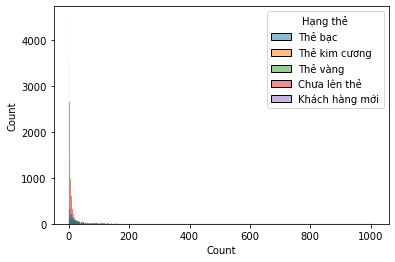

In [ ]:
#quan sát dữ liệu có xuất hiện out-liers
sns.histplot(data=no_transaction, x ='Count', hue = 'Hạng thẻ')


Quan sát phân phối giao dịch từ giá trị 2 đến 16 

trục hoành thể hiện mức tần suất giao dịch của từng nhóm khách hàng

trục tung thể hiện số lượng khách hàng tương ứng với từng mức tần suất

Hầu hết khách hàng trong nhóm này đều là nhóm khách hàng chưa lên thẻ, chú ý nhất có hơn 4000 khách là nhóm khách chỉ đến cửa hàng có 1 lần 

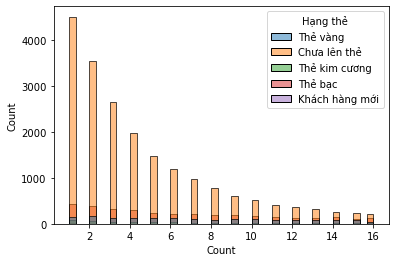

In [ ]:
#Xem xét tần suất giao dịch theo mức hạng thẻ
IQR = no_transaction[no_transaction['Count'] <=16]
sns.histplot(data=IQR, x ='Count', hue = 'Hạng thẻ')

Biểu đồ hộp thể hiện vùng giá trị tần suất giao dịch của từng nhóm khách hàng (phân theo hạng thẻ)

Trục tung thể hiện từng mức hạn giao dịch

Trục hoành thể hiện từng mức hạng thẻ

Quan sát ở nhóm khách có hạng thẻ kim cương có những quan sát nằm vượt trên vùng trên IQR ở mức 400. Điều này có nghĩa là biểu đồ cho rằng các khách hàng có tần suất giao dịch trên 400 lần được xem là giá trị ngoại lệ.

Vì nhắm để tránh để bị đánh giá lệch ước lượng tôi đã xem nhóm giao dịch trên 400 lần là giá trị anonymous và loại chúng ra khỏi bộ dữ liệu khi đem ước RFM (ở phần sau)

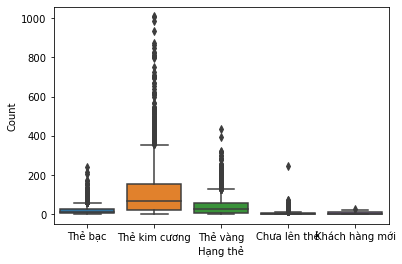

In [ ]:
sns.boxplot(x='Hạng thẻ', y='Count', data=no_transaction)

Quan sát phân phối tần suất giao dịch năm ngoài vùng IQR (từ mức tần suất 16 lần trở lên)

Ta thấy rõ phần lớn toàn là khách hàng thuộc nhóm thẻ Bạc (xanh dương), thẻ vàng (xanh lá), thẻ kim cương (màu vàng)

Điều này cũng hợp lý với nhóm khách hàng này với mức độ cam kết của họ càng cào thì mình sẽ họ sẽ có tần suất ghé cửa hàng nhiều hơn

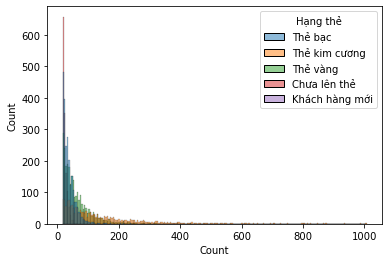

In [ ]:
#Xét số lần giao dịch nằm ngoài vùng IQR
un_IQR_no = no_transaction[no_transaction['Count'] >16]
#un_IQR_no
sns.histplot(data=un_IQR_no, x ='Count', hue = 'Hạng thẻ')

In [ ]:
#lấy ra mã của nhóm khách hàng có tần suất mua khủng
code = no_transaction[no_transaction['Count']>390]['Mã KH']


# Phân tích doanh thu đơn hàng

Xem xét đánh giá  trung bình doanh thu của từng nhóm hạng thẻ

In [ ]:
#Nhóm doanh thu theo từng phiếu
ro_df = pos_df.copy()
ro_df = ro_df.reset_index()
ro_df = ro_df[['Số phiếu','Ngày','Mã KH','Hạng thẻ','Doanh thu']]
ro_df['Sum_return'] = ro_df.groupby(['Số phiếu'])['Doanh thu'].transform('sum')
ro_df.drop(columns =['Mã KH','Ngày','Doanh thu'], inplace = True)
ro_df.drop_duplicates(inplace=True)

In [ ]:
ro_df.head()

,Số phiếu,Hạng thẻ,Sum_return
0,THNAA035512,Thẻ bạc,9.172727e+05
1,PCTAA056429,Thẻ kim cương,5.062727e+06
2,THNAA036658,Thẻ vàng,1.318182e+05
3,PCTAA068546,Thẻ kim cương,2.093636e+06
4,PCTAA063693,Thẻ vàng,5.595455e+06


In [ ]:
#Tổng doanh thu bán lẻ là 140,961,015,569.86148 đồng
ro_df['Sum_return'].sum()

140961015569.86148

In [ ]:
# Trung bình một đơn hàng cho ra là 847,019 đồng
# Trong đó 50% khách hàng mua đơn hàng cáo giá trị không vượt quá 459,090 đồng
ro_df['Sum_return'].describe()

count    1.664200e+05
mean     8.470197e+05
std      1.421259e+06
min      2.545454e+03
25%      2.045450e+05
50%      4.600000e+05
75%      9.609091e+05
max      1.014056e+08
Name: Sum_return, dtype: float64

Phân phối doanh thu của các phiếu bị các quan sát ngoại lệ khéo lệch

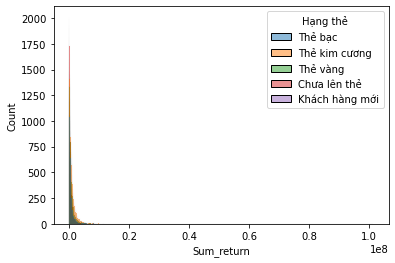

In [ ]:
#considering the client in IQR range
#IQR_return = ro_df[ro_df['Sum_return'] <=9.604545e+05]
sns.histplot(data=ro_df, x ='Sum_return', hue = 'Hạng thẻ')

Quan sát phân phối doanh thu từng phiếu trong khoảng từ 960,045 đồng trở xướng

Thấy được nhóm khách trong các mức này rất đan dạnh thấy rõ nhất là nhóm hạng thể vàng, bạc, kim cương

nhóm khách hàng chưa lên thẻ có các mức giao dịch nằm trong 450,000 đồng đổ về

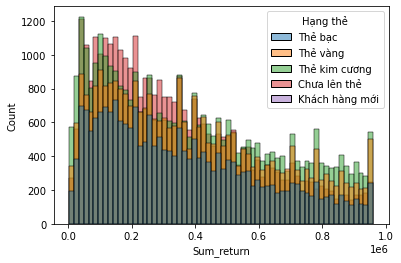

In [ ]:
#considering the client in IQR range
IQR_return = ro_df[ro_df['Sum_return'] <=9.604545e+05]
sns.histplot(data=IQR_return, x ='Sum_return', hue = 'Hạng thẻ')

Biều đồ thể hiện phân phối doanh thu với các đơn hàng từ 960,454 đồng trở lên

Bao phủ cả nhóm này đó là khách hàng thuộc nhóm hạng thẻ kim cương

Sâu trong phân phối vẫn có nhóm khách hàng thuộc hạng thẻ vàng và bạc

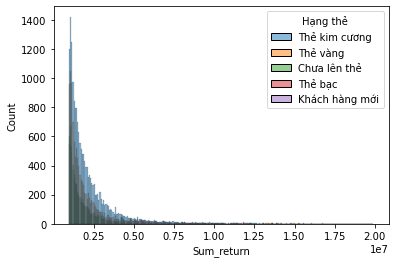

In [ ]:
#considering the client in IQR range
un_IQR_return = ro_df[ro_df['Sum_return'] >9.604545e+05]
un_IQR_return = un_IQR_return[un_IQR_return['Sum_return']< 0.2e+08]
sns.histplot(data=un_IQR_return, x ='Sum_return', hue = 'Hạng thẻ')

# Lọc các điểm dữ liệu bí ẩn khỏi bộ dữ liệu

In [ ]:
#lọc nhóm khách hàng có tần suất giao dịch cao bất thường ra khỏi bộ dữ liệu
kg_df = pos_df[pos_df['Mã KH'].isin(code)==False]


In [ ]:
modeling_df = kg_df.copy() #tạo cộ dữ liệu bản sao từ bộ dữ liệu Kg_df để mô hình hóa 
modeling_df.rename(columns={'Số phiếu':'orderid', 'Doanh thu':'Return'}, inplace=True) # Đổi tên vài trường thông tin để tiện cho việc truy xuất dữ liệu
modeling_df.shape

(610279, 38)

In [ ]:
del code, df, df_source, IQR, IQR_return, no_transaction, ro_df, un_IQR_no, un_IQR_return

In [ ]:
#Vì bộ dữ liệu này chứa thông tin mặt hàng theo từng đơn hàng nên cần nhóm chúng lại về dạng doanh thu theo từng đơn hàng để phù hợp với ước tính của RFM
modeling_df = modeling_df[['orderid','Ngày','Mã KH','Return']] #Lấy ra các thông tin cần thiết như mã đơn hành, ngày, mã khách hàng, doannh thu 
modeling_df['Sum_return'] = modeling_df.groupby(['orderid'])['Return'].transform('sum') #Nhóm hết doanh thu bằng việc cộng tổng các quan sát có cũng mã đơn hàng
modeling_df.drop(columns='Return', inplace=True) #Bỏ đi cột dữ liệu doanh thu
modeling_df.drop_duplicates(inplace=True) #Bỏ đi các quan sát trùng lặp được gây ra trong quá trình nhóm (lệnh sẽ không có hiệu lực nếu không bỏ đi cột doanh thu)

# Mồ hình hóa dữ liệu bằng mồ hình RFM

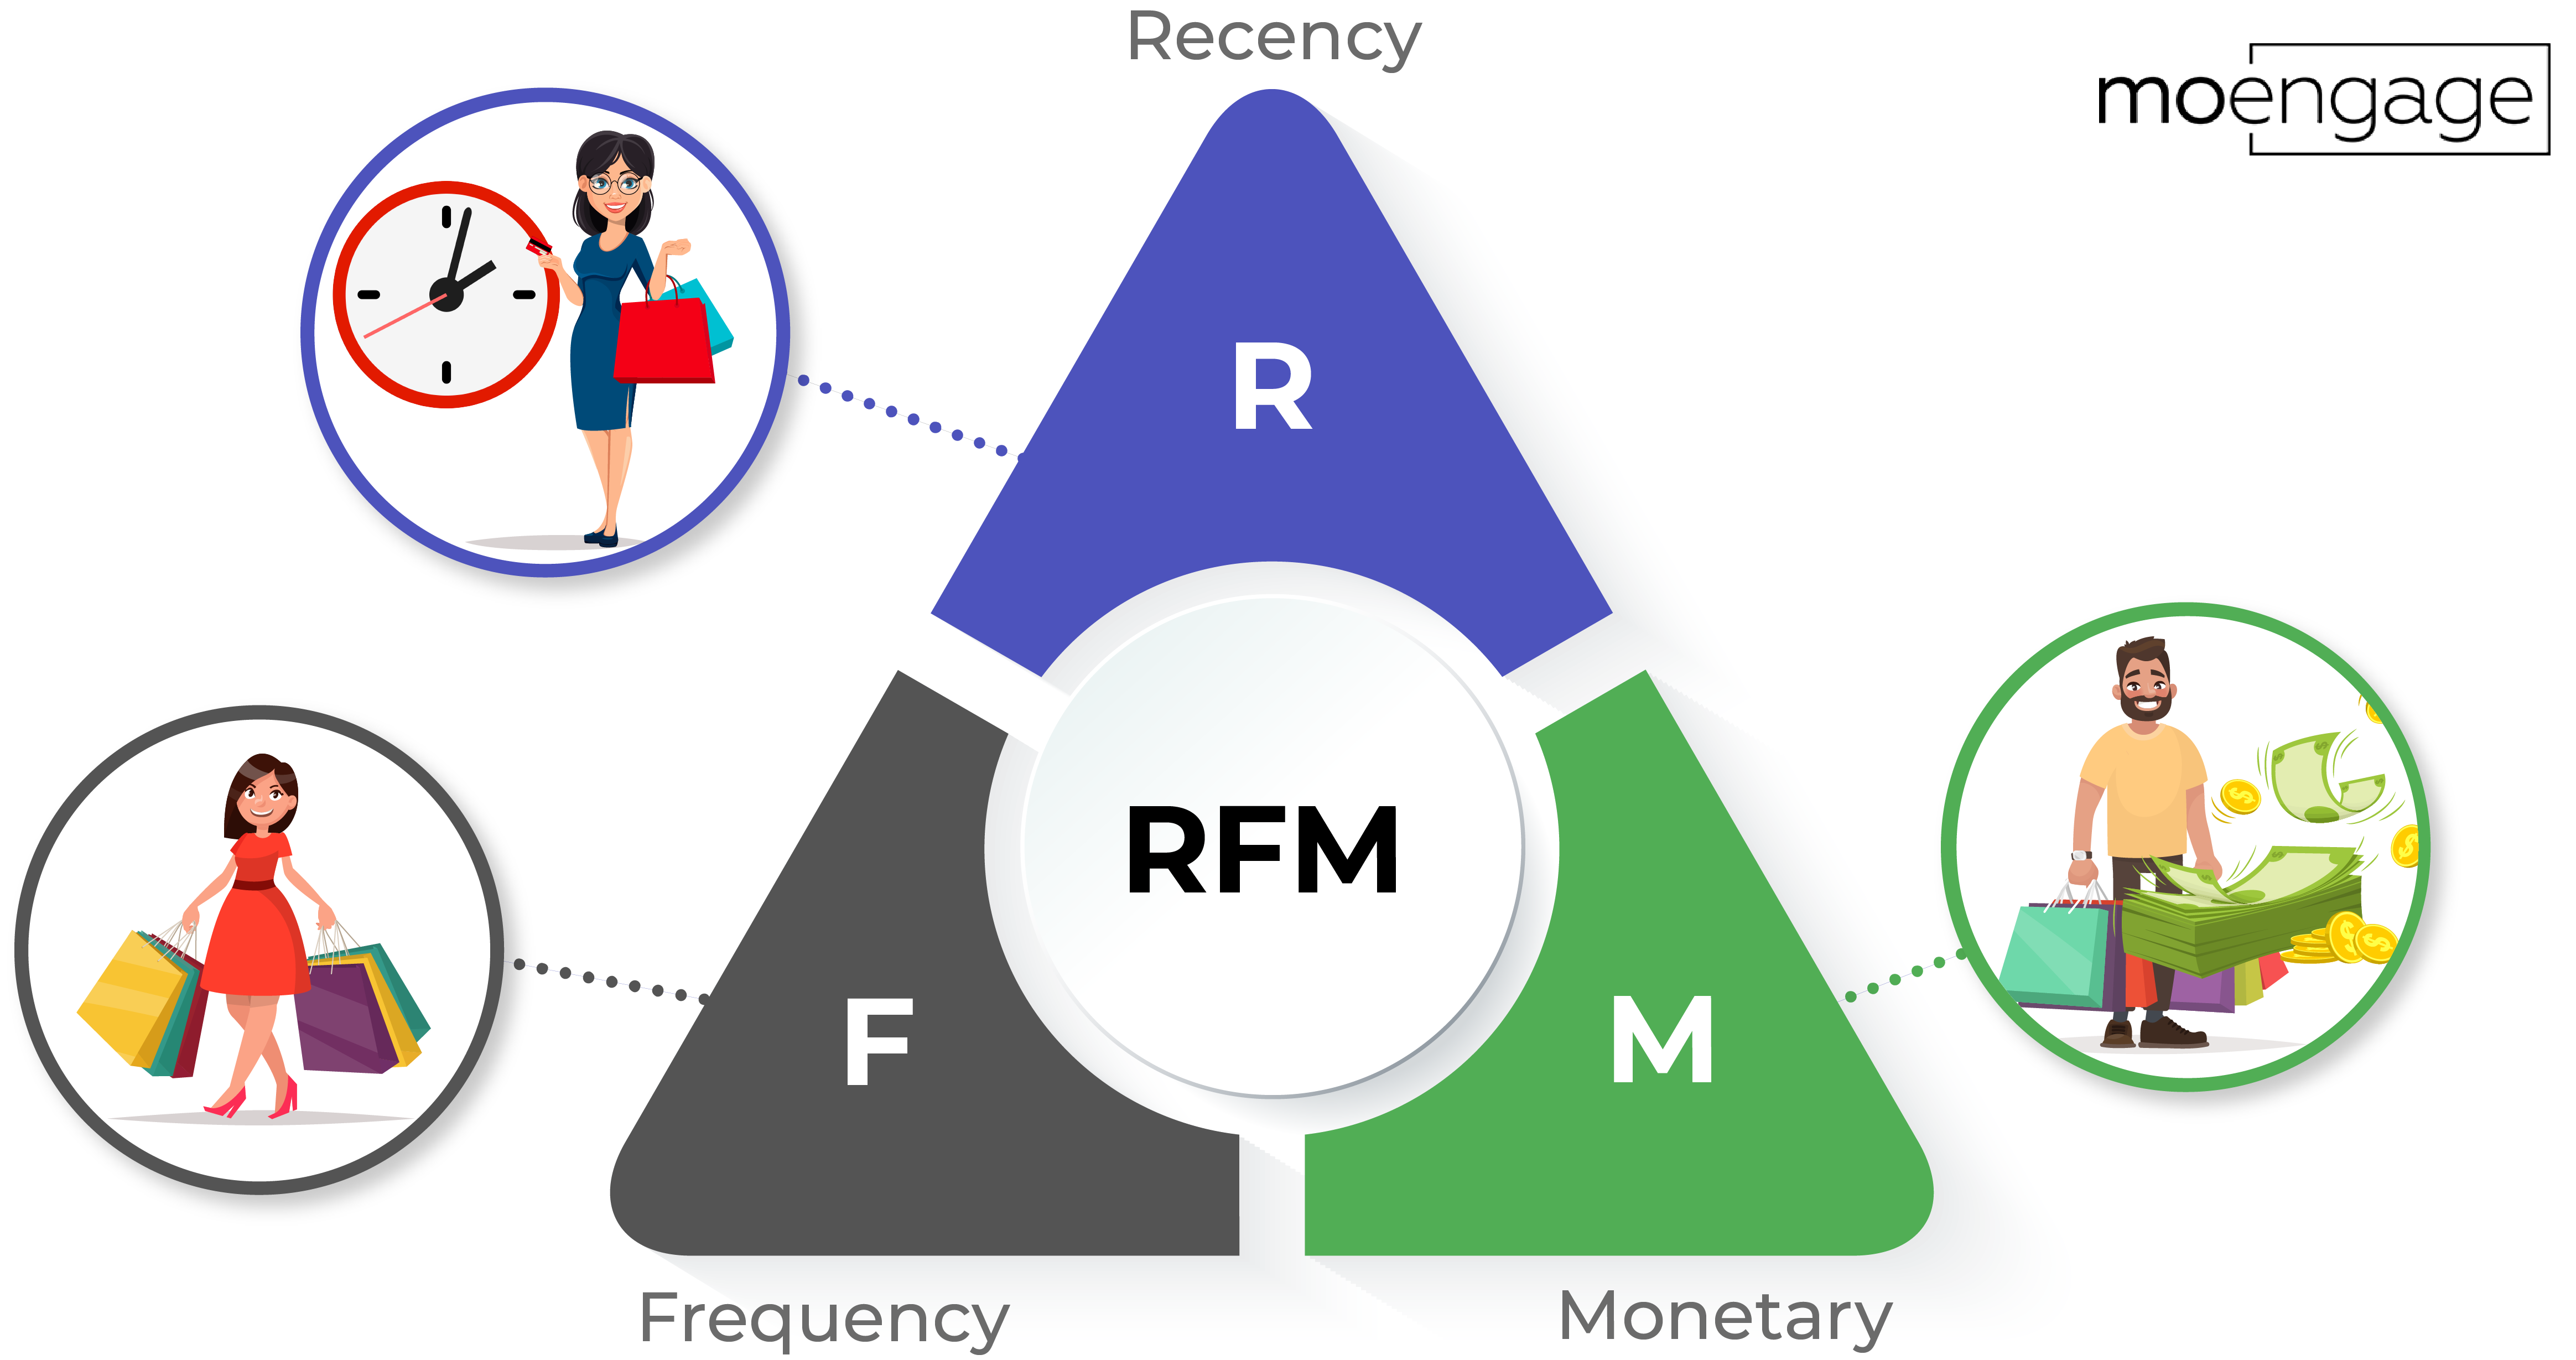

In [ ]:
from IPython.display import Image
Image(filename='title.png')

RFM là gì?

RFM là từ viết tắt của recency (gần đây), frequency (tần suất) và monetery (tiền tệ). 

Recency (lần truy cập gần đây) là đơn đặt hàng cuối cùng của khách hàng. Nó có nghĩa là số ngày kể từ khi khách hàng thực hiện lần mua hàng cuối cùng. Nếu đó là trường hợp của một trang web hoặc một ứng dụng, thì đây có thể được hiểu là ngày truy cập cuối cùng hoặc thời gian đăng nhập cuối cùng.

Frequency (Tần suất) là về số lần mua hàng trong một khoảng thời gian nhất định. Có thể là 3 tháng, 6 tháng hoặc 1 năm. Vì vậy, chúng ta có thể hiểu giá trị này là tần suất hoặc bao nhiêu khách hàng đã sử dụng sản phẩm của một công ty. Giá trị càng lớn thì khách hàng càng gắn bó. Chúng ta có thể nói họ là VIP của chúng ta không? Không cần thiết. Bởi vì chúng tôi cũng phải nghĩ về số tiền họ thực sự trả cho mỗi lần mua hàng, có nghĩa là giá trị tiền tệ.

Monetary (Tiền tệ) là tổng số tiền mà khách hàng đã chi tiêu trong khoảng thời gian nhất định đó. Do đó, những người chi tiêu lớn sẽ được phân biệt với những khách hàng khác như MVP hoặc VIP.

Tính giá trị Recency cho từng khách hàng

In [ ]:
a = modeling_df['Ngày'].max() #lấy mốc ngày xuất dữ liệu ngày 13 tháng 7 để tính giá trị Recency cho phù hợp
from datetime import datetime
#nhóm khách hàng theo ngày gần nhất mà họ đã giao dịch
dfRecentOrder = pd.pivot_table(data= modeling_df, index=['Mã KH'], values=['Ngày'], aggfunc={'Ngày':max}) #tạo ra một bảng pivot 
#chứa thông tin ngày giao dịch gần nhát với thời điểm 13thang7

dfRecentOrder.columns = ['RecentOrderDate']

modeling_df = pd.merge(modeling_df, dfRecentOrder.reset_index(), on=['Mã KH']) #gộp trường thông tin ngày giao dịch gần nhất vào bộ dữ liệu chung
#Recency = Ngày 13 tháng 7 - ngày gần nhất giao dịch
modeling_df['Recency'] = modeling_df['RecentOrderDate'].apply(lambda x: (a - x).days) #Tạo ra giá trị Recency bằng việc lấy ngày 13 tháng 7 trừ đi ngày giao dịch gần nhất

Tính giá trị Frequency cho từng khách hàng

In [ ]:
#Nhóm mã khách theo từng số phiếu mà họ đã giao dịch thành một dataframe
dfFrequency = modeling_df.groupby('Mã KH').orderid.nunique().to_frame() #tạo cột giá trị tần suất khách hàng bằng việc đếm mã đơn hàng theo hàm 
dfFrequency.columns = ['Frequency']
#sau đó nhóm chung về dữ liệu chung (modeling_df-để tiện xử lý)
modeling_df = pd.merge(modeling_df, dfFrequency.reset_index(), on='Mã KH') #gộp dữ liệu thông tin tần suất vào bộ dữ liệu chung 

In [ ]:
del dfFrequency, dfRecentOrder, a

Tính giá trị Monetary cho từng khách hàng

In [ ]:
#Nhóm mã khách hàng theo doanh thu thành một dataframe chưa thông tin tổng số tiền họ đã chi theo từng nhóm mã
dfMonetary = modeling_df.groupby('Mã KH').Sum_return.sum().to_frame() #tính Monetary của khách hàng bằng việc lấy tổng các đơn hàng theo từng khách hàng 
dfMonetary.columns = ['Monetery']
modeling_df = pd.merge(modeling_df, dfMonetary.reset_index(), on='Mã KH')
del dfMonetary

Standerlization ranking

In [ ]:
modeling_df.columns

Index(['orderid', 'Ngày', 'Mã KH', 'Sum_return', 'RecentOrderDate', 'Recency',
       'Frequency', 'Monetery'],
      dtype='object')

In [ ]:
#Tách dữ liệu RFM từ dữ liệu chung modeling và tiến hành phân điểm RFM trên đây
rfm = modeling_df[['Mã KH','Recency',
       'Frequency', 'Monetery']].set_index('Mã KH')
rfm.drop_duplicates(inplace=True)
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,33459.0,2.110520e+02,1.732870e+02,0.0000,53.00000,1.700000e+02,3.660000e+02,5.580000e+02
Frequency,33459.0,4.619923e+00,9.185074e+00,1.0000,1.00000,2.000000e+00,4.000000e+00,2.060000e+02
Monetery,33459.0,3.885527e+06,8.757088e+06,7272.7273,411717.17175,1.059630e+06,3.230708e+06,2.069433e+08


In [ ]:
rfm.shape

(33459, 3)

# Xếp hạng khách hàng chung bằng mô hình RFM 

In [ ]:
#Để phù hợp cho việc tính toán RFM chung cho toàn bộ cửa hàng
#lọc khách lẻ có định danh
rfm = rfm[rfm['Frequency']>1]
rfm.shape

(17682, 3)

Chúng tôi sẽ đánh giá khách hàng "Recency" hoạt động gần đây tốt hơn so với khách hàng ít gần đây hơn, bởi vì mỗi công ty đều muốn khách hàng của mình là những người gần đây

Chúng tôi sẽ xếp hạng nhãn "Frequency" và "Monetary" cao hơn vì chúng tôi muốn Khách hàng chi tiêu nhiều tiền hơn và truy cập thường xuyên hơn (đó là đơn đặt hàng khác với lần truy cập gần đây).

In [ ]:

rfm['R_Score'] = 1 #Nhóm khách hàng có Recency cao hơn 30 ngày cho 1 điểm
rfm.loc[(rfm['Recency'] <= 7) & (rfm['Recency'] >= 0), 'R_Score'] = 4 #Nhóm khách hàng có Recency thấp hơn 7 ngày cho 4 điểm
rfm.loc[(rfm['Recency'] > 7) & (rfm['Recency']<= 14), 'R_Score'] = 3 #Nhóm khách hàng có Recency  từ 7 đến 14 ngày cho 3 điểm
rfm.loc[(rfm['Recency'] > 14) & (rfm['Recency'] <=30), 'R_Score'] = 2 #Nhóm khách hàng có Recency  từ 7 đến 14 ngày cho 3 điểm



rfm['F_Score'] = 4 #Nhóm khách hàng có Frequency cao hơn 8 lần cho 4 điểm
rfm.loc[(rfm['Frequency'] <=2 ), 'F_Score'] = 1 #Nhóm khách hàng có Frequency thấp hơn 2 ngày cho 1 điểm
rfm.loc[(rfm['Frequency'] > 2) & (rfm['Frequency']<= 3), 'F_Score'] = 2 #Nhóm khách hàng có Frequency  từ 2 đến 3 ngày cho 2 điểm
rfm.loc[(rfm['Frequency'] > 3) & (rfm['Frequency'] <= 8), 'F_Score'] = 3 #Nhóm khách hàng có Frequency  từ 3 đến 8 ngày cho 3 điểm

#Monetary chia điểm theo phân vị nhóm 25% phân vị đầu cho 1 điểm, 25-50% cho 2 điểm, 50-75% cho 3 điểm, 75-100% cho 4 điểm
rfm["M_Score"] = pd.qcut(rfm["Monetery"],4,labels=[1,2,3,4])
#Tạo ra phân khúc RFM theo ba tiêu chí được tạo Receny-Frequency-Monetary
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
#Tính toán điểm RFM bằng việc lấy tổng ba tiêu chí
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
Mã KH,,,,,,,,
HN1AA093383,461,6,6.704307e+06,1,3,3,133,7.0
HN1AA000683,3,16,1.919067e+07,4,4,4,444,12.0
THNAA001065,32,42,3.401440e+07,1,4,4,144,9.0
PCTAA005958,6,19,2.546797e+07,4,4,4,444,12.0
HN1AA085295,145,10,1.147000e+07,1,4,4,144,9.0


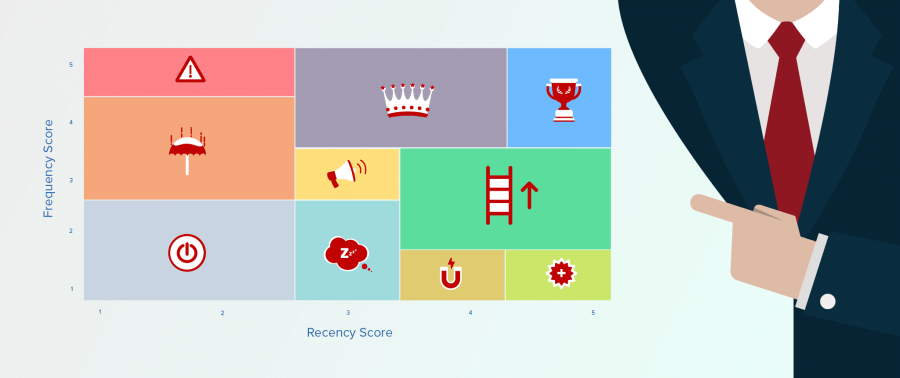

In [ ]:
Image(filename='matrix.png')

Phân khúc khách hàng theo Recency và Monetary

Lưu ý hình trên phân khúc theo 5 bậc hạng trong dự án này chỉ phân khúc theo 4 bậc hạng nên sẽ có chút khác biệt


*   Recency từ 1-2 + Frequency từ 1-2 = hiberating

Ý nghĩa nhóm khách hàng có tần suất giao dịch được 2 lần cộng với việc từ 15 đến hơn 90 ngày không giao dịch đã không giao dịch thì được xếp vào nhóm kế thừa


*   Recency từ 1-2 + Frequency từ 2-3 = at_risk 

Ý nghĩa nhóm khách hàng có tần suất giao dịch được 3 đến 8 lần cộng với việc  từ 15 đến hơn 90 ngày đã không giao dịch thì được xếp vào nhóm rủi ro.


*   Recency từ 1-2 + Frequency 4 = Can't loose

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 9-206 lần công với việc đã không giao dịch được khaonrg từ 15 đến hơn 90 ngày thì xếp vào nhóm không thể đánh mất.

*   Recency 2 + Frequency từ 1-2 = about to sleep

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 2-3 lần với việc đã từ 15-30 ngày không giao dịch thì được xếp vào nhóm sắp ngủ

*  Recency 2 + Frequency 2 = need attention

Ý nghĩa nhóm khách hàng có tần suất giao dịch được 3 lần với việc đã từ 15-30 ngày không giao dịch thì được xếp vào nhóm cần được quan tâm

*   Recency từ 2 đến 3 + Frequency từ 3 đến 4 = loyal customers

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 3 đến 8 lần với việc đã từ 8-30 ngày không giao dịch thì được xếp vào diện khách hàng trung thành.
*   Recency 3 + Frequency 1 = Promissing

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 4 đến 8 lần với việc đã từ 30 đến hơn 90 ngày không giao dịch thì được xếp vào diện khách hàng đầy hứa hẹn

*   Recency 4 + Frequency 1 = new customers

Ý nghĩa nhóm khách hàng có tần suất giao dịch được 2 lần với việc đã từ 0 đến 7 ngày không giao dịch thì được xếp vào diện khách hàng mới

*   Recency từ 3 đến 4 + Frequency từ 1 đến 2 = potetial loyalists

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 2 đến 3 lần với việc từ 0 đến 14 ngày không giao dịch thì được xếp vào diện khách hàng tiềm năng chung thành

*   Recency 4 + Frequency từ 3 đến 4 = champions

Ý nghĩa nhóm khách hàng có tần suất giao dịch từ 4 đến 206 lần cộng với việc từ 0 đến 7 ngày không giao dịch thì được xếp vào nhóm khách hàng vô địch





In [ ]:
seg_map = {r'[1-2][1-2]': 'hibernating', 
           r'[1-2][2-3]': 'at_Risk',  
           r'[1-2]4': 'cant_loose', 
           r'2[1-2]': 'about_to_sleep',
           r'22': 'need_attention',
           r'[2-3][3-4]': 'loyal_customers',
           r'31': 'promising',
           r'41': 'new_customers',
           r'[3-4][1-2]': 'potential_loyalists',
           r'4[3-4]': 'champions'}

rfm["Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)

rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
# List the head of the table to view the 
rfm.head()

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Score
Mã KH,,,,,,,,,,
HN1AA093383,461,6,6.704307e+06,1,3,3,133,7.0,at_Risk,Bronze
HN1AA000683,3,16,1.919067e+07,4,4,4,444,12.0,champions,Platinum
THNAA001065,32,42,3.401440e+07,1,4,4,144,9.0,cant_loose,Silver
PCTAA005958,6,19,2.546797e+07,4,4,4,444,12.0,champions,Platinum
HN1AA085295,145,10,1.147000e+07,1,4,4,144,9.0,cant_loose,Silver


Trong phần trên tôi còn phần điểm RFM thành các mức xếp hạng


*   Kim cương: Tổng điểm 3 tiêu chí trên 10
*   Vàng : Tổng điểm 3 tiêu chí trên 9 nhỏ hơn 10
*   Bạc : Tổng điểm 3 tiêu chí trên 7 nhỏ 9
*   Đồng: Tổng điểm 3 tiêu trên 5 nhỏ hơn 7
*   Xanh : Tổng điểm 3 tiêu chí nhỏ hơn 5









Đưa nhóm khách hàng thuộc top đầu (most valuable)

In [ ]:
rfm[rfm['Segment']=='champions'].head(10)

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Score
Mã KH,,,,,,,,,,
HN1AA000683,3,16,1.919067e+07,4,4,4,444,12.0,champions,Platinum
PCTAA005958,6,19,2.546797e+07,4,4,4,444,12.0,champions,Platinum
HN1AA568103,3,21,3.106629e+07,4,4,4,444,12.0,champions,Platinum
HN1AA538254,1,27,2.409790e+07,4,4,4,444,12.0,champions,Platinum
PCTAA003777,5,4,1.832895e+07,4,3,4,434,11.0,champions,Platinum
HN1AA553072,5,37,2.466562e+07,4,4,4,444,12.0,champions,Platinum
BC001109,1,101,6.167038e+07,4,4,4,444,12.0,champions,Platinum
HN1AA564875,6,39,4.551412e+07,4,4,4,444,12.0,champions,Platinum
HN1AA092769,1,8,4.579364e+06,4,3,3,433,10.0,champions,Gold


Thống kê mô tả của từng tiêu chí

In [ ]:
(rfm[["Segment","Recency","Frequency", "Monetery"]]
.groupby("Segment")
.agg(["mean","median","count","std","min","max","skew"])
)

Recency                                              \
                           mean median count         std min  max      skew   
Segment                                                                       
at_Risk              148.841170    109  4445  122.638762  15  557  1.097638   
cant_loose            78.788629     50  2867   76.349734  15  541  2.118954   
champions              3.725950      4  1237    2.060983   0    7  0.017850   
hibernating          227.823001    199  7904  157.366792  15  558  0.449541   
loyal_customers       11.025445     11   786    1.917234   8   14 -0.000413   
new_customers          3.675862      4   145    1.985653   0    7  0.140346   
potential_loyalists    7.213904      7   187    4.038420   0   14  0.109377   
promising             11.018018     11   111    1.911601   8   14  0.124938   

                     Frequency               ...                     \
                          mean median count  ... min  max      skew   
Segment                                      ...                      
at_Risk               5.404274      5  4445  ...   4    8  0.570887   
cant_loose           18.574119     14  2867  ...   9  197  4.895983   
champions            22.350040     15  1237  ...   4  206  2.960722   
hibernating           2.333629      2  7904  ...   2    3  0.705832   
loyal_customers      18.272265     12   786  ...   4  194  2.900870   
new_customers         2.000000      2   145  ...   2    2  0.000000   
potential_loyalists   3.000000      3   187  ...   3    3  0.000000   
promising             2.000000      2   111  ...   2    2  0.000000   

                         Monetery                                    \
                             mean        median count           std   
Segment                                                               
at_Risk              4.449655e+06  3.013636e+06  4445  4.649326e+06   
cant_loose           1.521650e+07  1.067363e+07  2867  1.461424e+07   
champions            1.917550e+07  1.201238e+07  1237  2.034763e+07   
hibernating          1.937994e+06  1.154545e+06  7904  2.666024e+06   
loyal_customers      1.600180e+07  9.304259e+06   786  1.936003e+07   
new_customers        1.882252e+06  1.129293e+06   145  2.417447e+06   
potential_loyalists  2.767108e+06  1.690236e+06   187  3.926845e+06   
promising            1.697388e+06  1.122273e+06   111  1.907810e+06   

                                                          
                             min           max      skew  
Segment                                                   
at_Risk              150000.0001  5.752221e+07  3.696537  
cant_loose           267609.4278  1.466687e+08  2.884135  
champions            595841.7508  1.407553e+08  1.977602  
hibernating           36181.8182  5.468273e+07  5.938641  
loyal_customers      272727.2727  2.069433e+08  3.208516  
new_customers         54545.4546  1.923493e+07  3.830548  
potential_loyalists  168181.8183  4.151882e+07  5.988014  
promising             86363.6364  1.316163e+07  3.188400  

[8 rows x 21 columns]

Biểu đồ cột ở dưới cho thấy các giá trị trung vị Recency của từng nhóm khách hàng

Ta có thể thấy được khoảng 50% khách hàng thuộc nhóm champion có thời điểm gần nhất giao dịch với cửa hàng là từ 4 ngày đổ về (từ thời điềm 13/7/2022)

Còn con số này ở 50% nhóm khách hàng thuộc hibernating(kế thừa) là 199 ngày

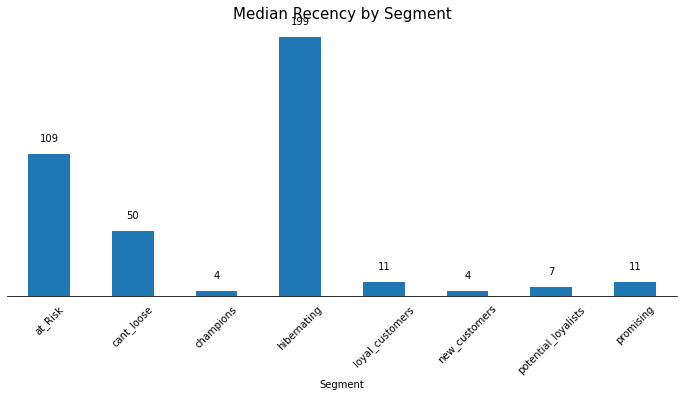

In [ ]:
#Recency plot
fig,ax = plt.subplots(figsize=(12,5))
rec_data = (rfm
            .groupby("Segment")
            .Recency
            .median()
            .head(10)
            )
(rec_data.plot.bar(ax=ax,rot=45))

ax.set_title("Median Recency by Segment",fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(rec_data):
    ax.text(pos, value+10, f"{value}",ha="center")

Biểu đồ cột ở dưới cho thấy các giá trị trung vị Frequency của từng nhóm khách hàng

Ta có thể thấy được khoảng 50% khách hàng thuộc nhóm champion có tần suất giao dịch với cửa hàng lớn nhất 15 lần

Còn con số này ở 50% nhóm khách hàng thuộc hibernating(kế thừa) là 2 lần

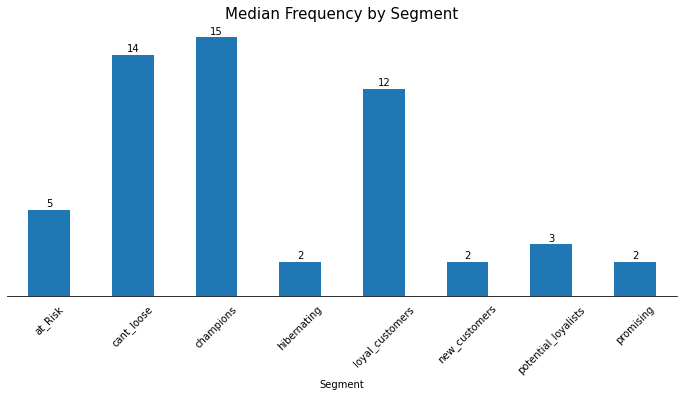

In [ ]:
#Frequency by Segment plot 
fig,ax = plt.subplots(figsize=(12,5))
freq_data = (rfm
            .groupby("Segment")
            .Frequency
            .median()
            .head(10)
            )
(freq_data.plot.bar(ax=ax,rot=45))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax.set_title("Median Frequency by Segment",fontsize=15)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(freq_data):
    ax.text(pos, value+0.2, f"{value}",ha="center")

Biểu đồ cột ở dưới cho thấy các giá trị trung vị Monetary của từng nhóm khách hàng

Ta có thể thấy được khoảng 50% khách hàng thuộc nhóm champion có đơn hàng trị giá lớn nhất 12 triệu đồng.

Còn con số này ở 50% nhóm khách hàng thuộc hibernating(kế thừa) là 1 triệu 154 nghìn đồng.

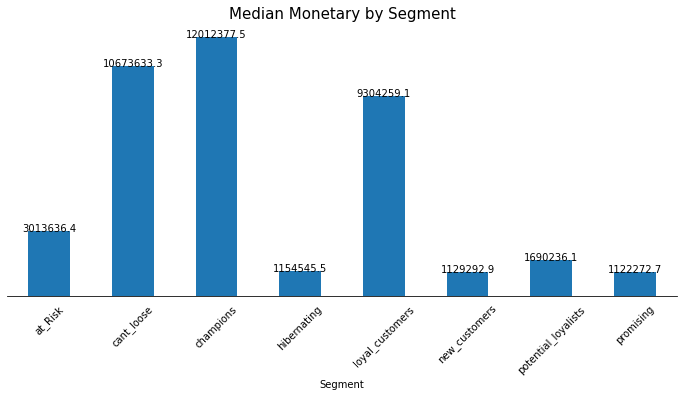

In [ ]:
#Monetary by Segment Plot
fig,ax = plt.subplots(figsize=(12,5))
mon_data = (rfm
            .groupby("Segment")
            .Monetery
            .median()
            .head(10)
            )
(mon_data.plot.bar(ax=ax,rot=45))

ax.set_title("Median Monetary by Segment",fontsize=15)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.get_yaxis().set_visible(False)
ax.tick_params(bottom=False)
for pos, value in enumerate(round(mon_data,1)):
    ax.text(pos, value+5, f"{value}",ha="center")

Biểu đồ bên dưới thể hiện mức độ tương quan mạnh yêu của từng nhóm khách hàng tương ứng với ba tiêu chí chính của RFM

Ta có thể ở các nhóm khách hàng thuộc nhóm plantinum có ô giá trị Recency rất thấp (-0.96, màu rất trắng) còn hai ô giá trị Frequency và Monetary (2.51 và 2.79, màu rất tối), điều này thể hiện rằng nhóm khách hàng có tần suất đang giao dịch rất thường xuyên và giá trị đơn hàng của họ rất lớn

Ngược lại khi quan sát nhóm khách xanh, tỷ lệ Recency mạnh tương đối ở cực dương (0.52) điều này cho thấy nhóm này đã tương đối lâu không quay lại các cửa hàng bán lẻ của SNB. Gía trị đơn hàng của hàng và tần suất giao dịch cũng thấp hơn so với nhóm giá trị đơn hàng và tần suất trung bình 0.2 lần.

Nhìn chung xu hương chung của biểu đồ nhiệt cho thấy rằng các khách hàng có độ cam kết với các của hàng bán lẻ thì họ sẽ càng có tần suất giao dịch nhiều và chi tiền mạnh cho các đơn hàng kèm theo việc thời gian giao dịch gần đây sẽ thấp.

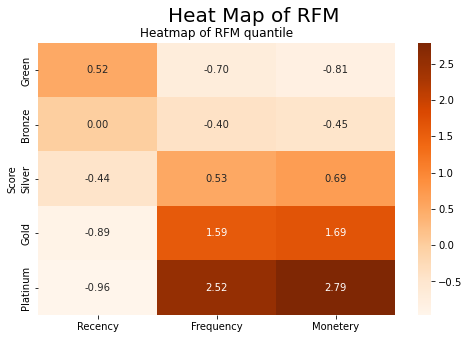

In [ ]:
'''
Các con số của từng vị trí trong ma trận được tính bằng cách lấy 
trung bình của từng nhóm khách ở một tiêu chí chia cho trung bình của tiêu chí đó rồi trừ đi cho 1
'''
# the mean value in total 
total_avg = rfm.loc[:, ['Recency','Frequency','Monetery']].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('Score').mean().loc[:,['Recency','Frequency','Monetery']]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm = prop_rfm.sort_values(by =['Recency'],ascending = False)
prop_rfm.round(2)
f, ax = plt.subplots(1, figsize=(8, 5))

sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax)
ax.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()

In [ ]:
del freq_data, mon_data, pos, prop_rfm, rec_data, rfm, seg_map, total_avg, value

In [ ]:
del ax, cluster_avg, f, fig

# Phân tích khách hàng thông qua RFM theo từng cửa hàng

Xây dựng mô hình RFM phân tích theo từng chi nhánh

Ở bước này nhóm tôi không lọc đi nhóm khách lẻ có định danh (Frequency = 1)

In [ ]:
#không lọc đi nhóm khách lẻ không định danh
rfm = modeling_df[['Mã KH','Recency',
       'Frequency', 'Monetery']].set_index('Mã KH')
rfm.drop_duplicates(inplace=True)
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,33459.0,2.110520e+02,1.732870e+02,0.0000,53.00000,1.700000e+02,3.660000e+02,5.580000e+02
Frequency,33459.0,4.619923e+00,9.185074e+00,1.0000,1.00000,2.000000e+00,4.000000e+00,2.060000e+02
Monetery,33459.0,3.885527e+06,8.757088e+06,7272.7273,411717.17175,1.059630e+06,3.230708e+06,2.069433e+08


In [ ]:
rfm['R_Score'] = 1
rfm.loc[(rfm['Recency'] <= 7) & (rfm['Recency'] >= 0), 'R_Score'] = 4
rfm.loc[(rfm['Recency'] > 7) & (rfm['Recency']<= 14), 'R_Score'] = 3
rfm.loc[(rfm['Recency'] > 14) & (rfm['Recency'] <=30), 'R_Score'] = 2



#rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"),4, labels=[1,2,3,4])
rfm['F_Score'] = 4
rfm.loc[(rfm['Frequency'] <=2 ), 'F_Score'] = 1
rfm.loc[(rfm['Frequency'] > 2) & (rfm['Frequency']<= 3), 'F_Score'] = 2
rfm.loc[(rfm['Frequency'] > 3) & (rfm['Frequency'] <= 8), 'F_Score'] = 3

rfm["M_Score"] = pd.qcut(rfm["Monetery"],4,labels=[1,2,3,4])
rfm["RFM_Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
#Calculate RFM score
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
Mã KH,,,,,,,,
HN1AA093383,461,6,6.704307e+06,1,3,4,134,8.0
HN1AA000683,3,16,1.919067e+07,4,4,4,444,12.0
THNAA001065,32,42,3.401440e+07,1,4,4,144,9.0
PCTAA005958,6,19,2.546797e+07,4,4,4,444,12.0
HN1AA085295,145,10,1.147000e+07,1,4,4,144,9.0


In [ ]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][2-3]': 'at_Risk',
           r'[1-2]4': 'cant_loose',
           r'2[1-2]': 'about_to_sleep',
           r'22': 'need_attention',
           r'[2-3][3-4]': 'loyal_customers',
           r'31': 'promising',
           r'41': 'new_customers',
           r'[3-4][1-2]': 'potential_loyalists',
           r'4[3-4]': 'champions'}

rfm["Segment"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str)
rfm["Segment"] = rfm["Segment"].replace(seg_map, regex=True)

rfm['Score'] = 'Green'
rfm.loc[rfm['RFM_Score']>5,'Score'] = 'Bronze' 
rfm.loc[rfm['RFM_Score']>7,'Score'] = 'Silver' 
rfm.loc[rfm['RFM_Score']>9,'Score'] = 'Gold' 
rfm.loc[rfm['RFM_Score']>10,'Score'] = 'Platinum'
# List the head of the table to view the 
rfm.head()

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Score
Mã KH,,,,,,,,,,
HN1AA093383,461,6,6.704307e+06,1,3,4,134,8.0,at_Risk,Silver
HN1AA000683,3,16,1.919067e+07,4,4,4,444,12.0,champions,Platinum
THNAA001065,32,42,3.401440e+07,1,4,4,144,9.0,cant_loose,Silver
PCTAA005958,6,19,2.546797e+07,4,4,4,444,12.0,champions,Platinum
HN1AA085295,145,10,1.147000e+07,1,4,4,144,9.0,cant_loose,Silver


In [ ]:
#đếm số quan sát chứa  khách hàng từng giao dịch với cửa hàng nào
store = kg_df[['Mã KH','Chi nhánh']].drop_duplicates()
store.set_index('Mã KH',inplace=True)
store.shape

(37730, 1)

In [ ]:
rfm_store = rfm.merge(store, left_index=True, right_index=True)
rfm_store.head()

,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Score,Chi nhánh
Mã KH,,,,,,,,,,,
#,84,2,1.951886e+06,1,1,3,113,5.0,hibernating,Green,LGI#SNB - Liễu Giai
#,84,2,1.951886e+06,1,1,3,113,5.0,hibernating,Green,HCM-SNB-ĐBP
+,368,1,5.454545e+04,1,1,1,111,3.0,hibernating,Green,PCT#SNB-PCT
000111222,227,1,1.590909e+05,1,1,1,111,3.0,hibernating,Green,THN#THNC
001349,473,1,3.818182e+06,1,1,4,114,6.0,hibernating,Bronze,LGI#SNB - Liễu Giai


In [ ]:
num_store = rfm_store['Chi nhánh'].reset_index()
num_store['Count'] = num_store.groupby(['Mã KH'])['Chi nhánh'].transform('count')
num_store.drop(columns='Chi nhánh', inplace=True)
num_store.drop_duplicates(inplace=True)
#lọc ra nhóm khách có giao dịch tại hai chi nhánh trở lên
cross_store_cuss = num_store[num_store['Count']>1]['Mã KH']


In [ ]:
rfm_store = rfm_store.reset_index()
#chia thành 2 tập dữ liệu
uni_store_rfm = rfm_store[rfm_store['Mã KH'].isin(cross_store_cuss)==False] #nhóm khách hàng chỉ giao dịch duy nhất 1 chi nhánh
multi_store_rfm = rfm_store[rfm_store['Mã KH'].isin(cross_store_cuss)==True] #nhóm khách hàng giao dịch từ 2 chi nhánh trở lên

In [ ]:
del cross_store_cuss, kg_df, num_store, rfm, rfm_store, store

In [ ]:
#Xuất dữ liệu hai nhóm khách hàng
multi_store_rfm.to_excel('multi_store_rfm.xlsx')
uni_store_rfm.to_excel('uni_store_rfm.xlsx')

In [ ]:
uni_store_rfm.head()

,Mã KH,Recency,Frequency,Monetery,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment,Score,Chi nhánh
2,+,368,1,5.454545e+04,1,1,1,111,3.0,hibernating,Green,PCT#SNB-PCT
3,000111222,227,1,1.590909e+05,1,1,1,111,3.0,hibernating,Green,THN#THNC
4,001349,473,1,3.818182e+06,1,1,4,114,6.0,hibernating,Bronze,LGI#SNB - Liễu Giai
5,00159467,416,1,2.227273e+05,1,1,1,111,3.0,hibernating,Green,THN#THNC
6,002514,261,3,1.204545e+06,1,2,3,123,6.0,hibernating,Bronze,THN#THNC


In [ ]:
num_cus_each_store = pd.DataFrame()
num_cus_each_store['Number'] = uni_store_rfm['Chi nhánh'].value_counts().sort_values(ascending=True)
num_cus_each_store

,Number
HCM-SNB-ĐBP,2086
JIS#SNB-JIS,4256
LGI#SNB - Liễu Giai,4506
THN#THNC,6345
PCT#SNB-PCT,12853


Biểu đồ bên dưới cho thấy được số lượng khách hàng trong từng cửa hàng trong suốt năm qua. 

Ta có thể thấy chi nhánh có nhiều khách hàng nhất đó là chi nhánh Phan Chu Trinh Hà Nội với hơn 12850 khách hàng. Số lượng khách hàng của chi nhánh này gần như chiếm gần 43% tổng toàn bộ khách hàng của các hàng bán lẻ. 

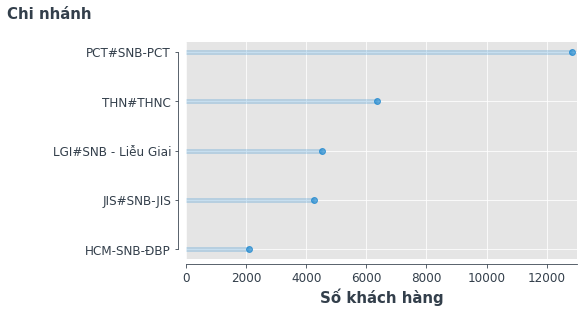

In [ ]:
plt.style.available
plt.style.use('ggplot')


# chỉnh font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'



# trước tiên chúng ta cần một trình giữ chỗ số cho trục y
my_range=list(range(1,len(num_cus_each_store.index)+1))

fig, ax = plt.subplots(figsize=(7,4))

# tạo cho mỗi chi nhánh nhập một đường ngang bắt đầu từ x = 0 với độ dài
# được thể hiện bằng giá trị tổng doanh thu
plt.hlines(y=my_range, xmin=0, xmax=num_cus_each_store, color='#007ACC', alpha=0.2, linewidth=5)

# Tạo ra mỗi đường doanh thu một chấm o theo từng chừng chi nhánh
plt.plot(num_cus_each_store['Number'], my_range, "o", color='#007ACC', alpha=0.6)

# chỉnh nnhax
ax.set_xlabel('Số khách hàng', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# chỉnh tọa độ
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, num_cus_each_store.index)

# thêm nhãn ngang cho trục tung
fig.text(-0.23, 0.96, 'Chi nhánh', fontsize=15, fontweight='black', color = '#333F4B')

# đổi kiểu cho trục gai
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0,13000)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

plt.savefig('hist2.png', dpi=300, bbox_inches='tight')

Hầu hết khách hàng của các cửa hàng phấn lớn đều là khách vãng lai (Chiếm 75,4%), đây là nhóm khách hàng chỉ có đến cửa hàng trong thời điểm rất lâu trước đây và tần suất giao dịch của họ không vượt quá ba lần.

Ngoài ra 11,2% nhóm khách hàng được xem vào dạng có rủi ro (at risk), nhóm khách hàng đã có đến cửa hàng trong thời điểm rất lâu trước đây và tần suất giao dịch của họ từ 2 đến 8 lần với cửa hàng.

=> Điều này cho thấy cách vận hành của của các cửa hàng bán lẻ phần lớn có sự thu hút đặc biệt với khách lẻ, chưa thể thu hút khách hàng để tạo sự commitment giữa hai bên. Phân loại của mô hình RFM cho thấy toàn bộ cửa hàng có tỷ lệ khách hàng trung thành không vượt quá 3%

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


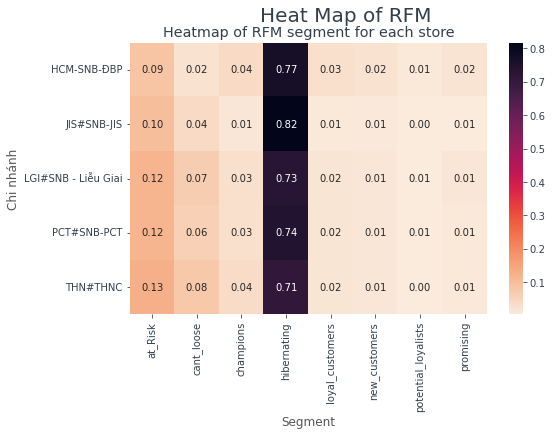

In [ ]:
#Tạo ra một bảng pivot của các mức xếp hạng khách hàng theo từng chi nhánh
No_segment_store = pd.crosstab(uni_store_rfm['Chi nhánh'], uni_store_rfm['Segment'], normalize='index')
f, ax = plt.subplots(1, figsize=(8, 5))

#Vẽ bảng pivot như một cái heatmap với những ô mật độ càng cao thì màu càng đậm và ngược lại
sns.heatmap(No_segment_store, cmap= 'rocket_r', fmt= '.2f', annot = True,ax=ax)
ax.set(title = "Heatmap of RFM segment for each store")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()

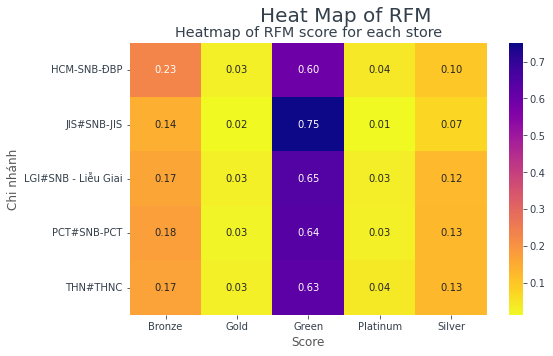

In [ ]:
#Tạo ra bảng pivot của khách theo từng chi nhánh tùy theo mức xếp hạng điểm RFM
No_segment_store = pd.crosstab(uni_store_rfm['Chi nhánh'], uni_store_rfm['Score'], normalize='index')
f, ax = plt.subplots(1, figsize=(8, 5))

sns.heatmap(No_segment_store, cmap= 'plasma_r', fmt= '.2f', annot = True,ax=ax)
ax.set(title = "Heatmap of RFM score for each store")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()